In [1]:
import numpy as np
import scipy.interpolate as interp
import scipy.optimize as opt
import matplotlib.pyplot as plt
import scipy.sparse as sp
import tabulate as tab

In [2]:
def aposterror(M,f,kfct,cfct,al,ar,v,w,k,N_int):
    X = np.linspace(v,w,N_int)
    N = np.zeros(k,dtype=np.int64)
    U = np.zeros([k,N_int])

    for j in range(k):
        N[j] = 5*2**(j+2)
        U[j,:] = M(f,kfct,cfct,al,ar,v,w,N[j],N_int)[1]
    
    Err = np.zeros(k); Delta = np.zeros(k)
    Err[0] = float('NaN'); Err[1] = float('NaN'); Delta[0] = float('NaN')
    Delta[1] = max(abs(U[1,:]-U[0,:]))
    for j in range(k-2):
        Delta[j+2] = max(abs(U[j+2,:]-U[j+1,:]))
        Err[j+2] = Delta[j+1]/Delta[j+2]

    return N,Delta,Err

In [3]:
# Solve the 1D Boundary Value Problem -u''+cu'+ku=f on an interval (u,v) with Dirichlet boundary conditions u(v)=al, u(w)=ar; with n nodes and N_int interpolation points
def FinDiffdd(f,kfct,cfct,al,ar,v,w,n,N_int):
    # Setup mesh
    [x,h] = np.linspace(v,w,n,retstep=True)

    # Compute matrices for u'', u', and u separately
    # Construct sparse matrix
    I = np.zeros(3*(n-2)+2); J = np.zeros(3*(n-2)+2); L = np.zeros(3*(n-2)+2)
    I[0] = 0; I[-1] = n-1; J[0] = 0; J[-1] = n-1; L[0] = 1; L[-1] = 1
    for k in range(1,n-1):
        I[[3*k-2,3*k-1,3*k]] = [k,k,k]
        J[[3*k-2,3*k-1,3*k]] = [k-1,k,k+1]
        L[[3*k-2,3*k-1,3*k]] = [-1-cfct(x[k])*h/2,2+h**2*kfct(x[k]),cfct(x[k])*h/2-1]/h**2

    A = sp.csr_matrix((L, (I, J)), shape=(n, n))

    # Construct the target vector
    b = np.zeros(n); b[0] = al; b[n-1] = ar
    for k in range(1,n-1):
        b[k] = f(x[k])

    # Solution
    u = sp.linalg.spsolve(A,b)

    # Interpolate
    X = np.linspace(v,w,N_int)
    Y = interp.interp1d(x,u,kind='cubic')(X)

    return X,Y

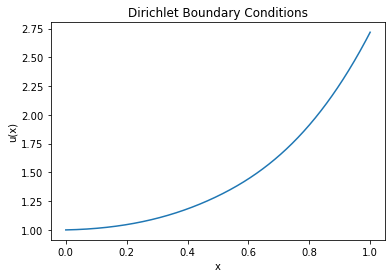

╒══════════╤═══════════════╤════════════════╕
│   #Nodes │         Delta │   Order of Cvg │
╞══════════╪═══════════════╪════════════════╡
│       20 │ nan           │      nan       │
├──────────┼───────────────┼────────────────┤
│       40 │   0.000481712 │      nan       │
├──────────┼───────────────┼────────────────┤
│       80 │   0.000113855 │        4.23093 │
├──────────┼───────────────┼────────────────┤
│      160 │   2.76602e-05 │        4.1162  │
├──────────┼───────────────┼────────────────┤
│      320 │   6.81608e-06 │        4.05808 │
├──────────┼───────────────┼────────────────┤
│      640 │   1.69171e-06 │        4.02912 │
├──────────┼───────────────┼────────────────┤
│     1280 │   4.21387e-07 │        4.01461 │
├──────────┼───────────────┼────────────────┤
│     2560 │   1.05158e-07 │        4.0072  │
├──────────┼───────────────┼────────────────┤
│     5120 │   2.62774e-08 │        4.00182 │
├──────────┼───────────────┼────────────────┤
│    10240 │   6.56029e-09 │      

In [5]:
cfct = lambda y: np.exp(-y**2); kfct = lambda y: 2*(2*y**2+1); f = lambda y: 2*y

X,Y = FinDiffdd(f,kfct,cfct,1,np.exp(1),0,1,5,1000)

plt.figure(1)
plt.plot(X,Y)
plt.ylabel('u(x)')
plt.xlabel('x')
plt.title('Dirichlet Boundary Conditions')
plt.show()

n_ref = 10
N,Delta,Err = aposterror(FinDiffdd,f,kfct,cfct,1,np.exp(1),0,1,n_ref,100000)

data = [['#Nodes','Delta','Order of Cvg']] + [[N[j],Delta[j],Err[j]] for j in range(n_ref)]
table = tab.tabulate(data,headers='firstrow',tablefmt='fancy_grid')

print(table)

In [6]:
# Solve the 1D Boundary Value Problem -u''+cu'+ku=f on an interval (u,v) with Neumann/Dirichlet boundary conditions u'(v)=al, u(w)=ar; with n nodes and N_int interpolation points
def FinDiffnd(f,kfct,cfct,al,ar,v,w,n,N_int):
    # Setup mesh
    [x,h] = np.linspace(v,w,n,retstep=True)

    # Construct sparse matrix
    I = np.zeros(3*(n-1)); J = np.zeros(3*(n-1)); L = np.zeros(3*(n-1))
    I[0] = 0; I[-1] = n-1; J[0] = 0; J[-1] = n-1; L[0] = 2/(h**2)+kfct(v); L[-1] = 1; I[-2] = 0; J[-2] = 1; L[-2] = -2/(h**2)
    for k in range(1,n-1):
        I[[3*k-2,3*k-1,3*k]] = [k,k,k]
        J[[3*k-2,3*k-1,3*k]] = [k-1,k,k+1]
        L[[3*k-2,3*k-1,3*k]] = [-1-cfct(x[k])*h/2,2+h**2*kfct(x[k]),cfct(x[k])*h/2-1]/h**2

    A = sp.csr_matrix((L, (I, J)), shape=(n, n))
    
    # Construct the target vector
    b = np.zeros(n); b[0] = f(v)-(2/h+cfct(v))*al; b[n-1] = ar
    for k in range(1,n-1):
        b[k] = f(x[k])

    # Solution
    u = sp.linalg.spsolve(A,b)

    # Interpolate
    X = np.linspace(v,w,N_int)
    Y = interp.interp1d(x,u,kind='cubic')(X)

    return X,Y

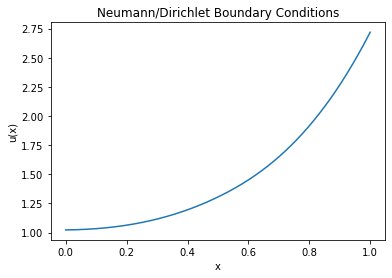

╒═══════════╤═══════════════╤════════════════╕
│   # Nodes │         Delta │   Order of Cvg │
╞═══════════╪═══════════════╪════════════════╡
│        20 │ nan           │      nan       │
├───────────┼───────────────┼────────────────┤
│        40 │   0.000780527 │      nan       │
├───────────┼───────────────┼────────────────┤
│        80 │   0.000183438 │        4.25499 │
├───────────┼───────────────┼────────────────┤
│       160 │   4.45041e-05 │        4.12182 │
├───────────┼───────────────┼────────────────┤
│       320 │   1.09627e-05 │        4.05959 │
├───────────┼───────────────┼────────────────┤
│       640 │   2.72062e-06 │        4.02948 │
├───────────┼───────────────┼────────────────┤
│      1280 │   6.77676e-07 │        4.01464 │
├───────────┼───────────────┼────────────────┤
│      2560 │   1.6911e-07  │        4.0073  │
├───────────┼───────────────┼────────────────┤
│      5120 │   4.22819e-08 │        3.99959 │
├───────────┼───────────────┼────────────────┤
│     10240 │

In [8]:
cfct = lambda y: np.exp(-y**2); kfct = lambda y: 2*(2*y**2+1); f = lambda y: 2*y

X,Y = FinDiffnd(f,kfct,cfct,0,np.exp(1),0,1,5,10000)

plt.figure(1)
plt.plot(X,Y)
plt.ylabel('u(x)')
plt.xlabel('x')
plt.title('Neumann/Dirichlet Boundary Conditions')
plt.show()

n_ref = 10
N,Delta,Err = aposterror(FinDiffnd,f,kfct,cfct,0,np.exp(1),0,1,n_ref,100000)

data = [['# Nodes','Delta','Order of Cvg']] + [[N[j],Delta[j],Err[j]] for j in range(n_ref)]
table = tab.tabulate(data,headers='firstrow',tablefmt='fancy_grid')

print(table)

In [9]:
# Solve the 1D Boundary Value Problem -u''+cu'+ku=f on an interval (u,v) with Dirichlet/Neumann boundary conditions u(v)=al, u'(w)=ar; with n nodes and N_int interpolation points
def FinDiffdn(f,kfct,cfct,al,ar,v,w,n,N_int):
    # Setup mesh
    [x,h] = np.linspace(v,w,n,retstep=True)

    # Construct sparse matrix
    I = np.zeros(3*(n-1)); J = np.zeros(3*(n-1)); L = np.zeros(3*(n-1))
    I[0] = 0; I[-1] = n-1; J[0] = 0; J[-1] = n-1; L[0] = 1; L[-1] = 2/(h**2)+kfct(w); I[-2] = n-1; J[-2] = n-2; L[-2] = -2/(h**2)
    for k in range(1,n-1):
        I[[3*k-2,3*k-1,3*k]] = [k,k,k]
        J[[3*k-2,3*k-1,3*k]] = [k-1,k,k+1]
        L[[3*k-2,3*k-1,3*k]] = [-1-cfct(x[k])*h/2,2+h**2*kfct(x[k]),cfct(x[k])*h/2-1]/h**2

    A = sp.csr_matrix((L, (I, J)), shape=(n, n))
    
    # Construct the target vector
    b = np.zeros(n); b[0] = al; b[n-1] = f(w)+(2/h-cfct(w))*ar
    for k in range(1,n-1):
        b[k] = f(x[k])

    # Solution
    u = sp.linalg.spsolve(A,b)

    # Interpolate
    X = np.linspace(v,w,N_int)
    Y = interp.interp1d(x,u,kind='cubic')(X)

    return X,Y

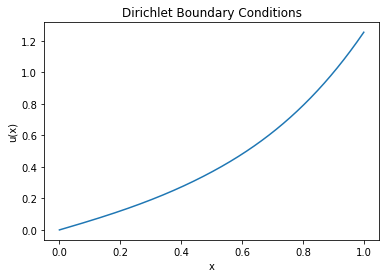

╒═══════════╤═══════════════╤════════════════╕
│   # Nodes │         Delta │   Order of Cvg │
╞═══════════╪═══════════════╪════════════════╡
│        20 │ nan           │      nan       │
├───────────┼───────────────┼────────────────┤
│        40 │   0.00262643  │      nan       │
├───────────┼───────────────┼────────────────┤
│        80 │   0.000618587 │        4.24585 │
├───────────┼───────────────┼────────────────┤
│       160 │   0.000150152 │        4.11974 │
├───────────┼───────────────┼────────────────┤
│       320 │   3.69915e-05 │        4.05909 │
├───────────┼───────────────┼────────────────┤
│       640 │   9.18049e-06 │        4.02936 │
├───────────┼───────────────┼────────────────┤
│      1280 │   2.28683e-06 │        4.0145  │
├───────────┼───────────────┼────────────────┤
│      2560 │   5.70685e-07 │        4.00718 │
├───────────┼───────────────┼────────────────┤
│      5120 │   1.42378e-07 │        4.00824 │
├───────────┼───────────────┼────────────────┤
│     10240 │

In [10]:
cfct = lambda y: 1; kfct = lambda y: y; f = lambda y: y**3 - 3*y**2
# cfct = lambda y: np.exp(-y**2); kfct = lambda y: 2*(2*y**2+1); f = lambda y: 2*y

X,Y = FinDiffdn(f,kfct,cfct,0,3,0,1,5,100000)

plt.figure(1)
plt.plot(X,Y)
plt.ylabel('u(x)')
plt.xlabel('x')
plt.title('Dirichlet Boundary Conditions')
plt.show()

n_ref = 10
N,Delta,Err = aposterror(FinDiffdn,f,kfct,cfct,0,3,0,1,n_ref,100000)

data = [['# Nodes','Delta','Order of Cvg']] + [[N[j],Delta[j],Err[j]] for j in range(n_ref)]
table = tab.tabulate(data,headers='firstrow',tablefmt='fancy_grid')

print(table)

In [11]:
def aposterrorR(M,f,kfct,cfct,alpha,al,ar,v,w,k,N_int):
    X = np.linspace(v,w,N_int)
    N = np.zeros(k,dtype=np.int64)
    U = np.zeros([k,N_int])

    for j in range(k):
        N[j] = 5*2**(j+2)
        U[j,:] = M(f,kfct,cfct,alpha,al,ar,v,w,N[j],N_int)[1]
    
    Err = np.zeros(k); Delta = np.zeros(k)
    Err[0] = float('NaN'); Err[1] = float('NaN'); Delta[0] = float('NaN')
    Delta[1] = max(abs(U[1,:]-U[0,:]))
    for j in range(k-2):
        Delta[j+2] = max(abs(U[j+2,:]-U[j+1,:]))
        Err[j+2] = Delta[j+1]/Delta[j+2]

    return N,Delta,Err

In [12]:
# Solve the 1D Boundary Value Problem -u''+cu'+ku=f on an interval (u,v) with Dirichlet/Robin boundary conditions u(v)=al, u'(w)+alpha*u(w)=ar; with n nodes and N_int interpolation points
def FinDiffdr(f,kfct,cfct,alpha,al,ar,v,w,n,N_int):
    # Setup mesh
    [x,h] = np.linspace(v,w,n,retstep=True)

    # Construct sparse matrix
    I = np.zeros(3*(n-1)); J = np.zeros(3*(n-1)); L = np.zeros(3*(n-1))
    I[0] = 0; I[-1] = n-1; J[0] = 0; J[-1] = n-1; L[0] = 1; L[-1] = 2*(1+alpha*h)/(h**2)+kfct(w)-alpha*cfct(w); I[-2] = n-1; J[-2] = n-2; L[-2] = -2/(h**2)
    for k in range(1,n-1):
        I[[3*k-2,3*k-1,3*k]] = [k,k,k]
        J[[3*k-2,3*k-1,3*k]] = [k-1,k,k+1]
        L[[3*k-2,3*k-1,3*k]] = [-1-cfct(x[k])*h/2,2+h**2*kfct(x[k]),cfct(x[k])*h/2-1]/h**2

    A = sp.csr_matrix((L, (I, J)), shape=(n, n))
    
    # Construct the target vector
    b = np.zeros(n); b[0] = al; b[n-1] = f(w)+(2/h-cfct(w))*ar
    for k in range(1,n-1):
        b[k] = f(x[k])

    # Solution
    u = sp.linalg.spsolve(A,b)

    # Interpolate
    X = np.linspace(v,w,N_int)
    Y = interp.interp1d(x,u,kind='cubic')(X)

    return X,Y

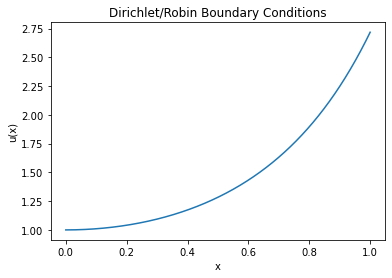

╒═══════════╤═══════════════╤════════════════╕
│   # Nodes │         Delta │   Order of Cvg │
╞═══════════╪═══════════════╪════════════════╡
│        20 │ nan           │      nan       │
├───────────┼───────────────┼────────────────┤
│        40 │   0.00323935  │      nan       │
├───────────┼───────────────┼────────────────┤
│        80 │   0.00076474  │        4.23589 │
├───────────┼───────────────┼────────────────┤
│       160 │   0.000185732 │        4.11744 │
├───────────┼───────────────┼────────────────┤
│       320 │   4.57632e-05 │        4.05854 │
├───────────┼───────────────┼────────────────┤
│       640 │   1.13578e-05 │        4.02922 │
├───────────┼───────────────┼────────────────┤
│      1280 │   2.82913e-06 │        4.0146  │
├───────────┼───────────────┼────────────────┤
│      2560 │   7.05997e-07 │        4.00729 │
├───────────┼───────────────┼────────────────┤
│      5120 │   1.76329e-07 │        4.00387 │
├───────────┼───────────────┼────────────────┤
│     10240 │

In [13]:
cfct = lambda y: np.exp(-y**2); kfct = lambda y: 2*(2*y**2+1); f = lambda y: 2*y

X,Y = FinDiffdr(f,kfct,cfct,2,1,4*np.exp(1),0,1,100,100000)

plt.figure(1)
plt.plot(X,Y)
plt.ylabel('u(x)')
plt.xlabel('x')
plt.title('Dirichlet/Robin Boundary Conditions')
plt.savefig('Dirichlet-Robin.png')
plt.show()

n_ref = 10
N,Delta,Err = aposterrorR(FinDiffdr,f,kfct,cfct,2,1,4*np.exp(1),0,1,n_ref,100000)

data = [['# Nodes','Delta','Order of Cvg']] + [[N[j],Delta[j],Err[j]] for j in range(n_ref)]
table = tab.tabulate(data,headers='firstrow',tablefmt='fancy_grid')

print(table)